In [1]:
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import nibabel as nib

from IPython.display import FileLink

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def fast_display(*img2dlst, titles=None):
    plt.figure(figsize=(16, 8))
    nbimg = len(img2dlst)
    cols = min(9, nbimg)
    rows = (nbimg // cols) + 1
    for ii, (img2d, title) in enumerate(zip(img2dlst, titles)):
        plt.subplot(rows, cols, 1+ii)
        plt.imshow(img2d)
        plt.title(title)
    plt.show()
    
def PrintSlices(img, titles=None):
    sx, sy, sz = img.shape
    fast_display(img[sx//2, :, :], img[:, sy//2, :], img[:, :, sz//2], titles=['Sagittale', 'Coronale', 'Axiale'])
    
def PrintData(name):
    data = nib.load(name).get_fdata()
    print(f"Coupes de {name[16:-4]}")
    PrintSlices(data)

In [3]:
os.chdir('../input/my-brats/')

In [4]:
filenames = os.listdir('./')
filenames.sort()

Nouveau patient :  00000
Coupes de t2


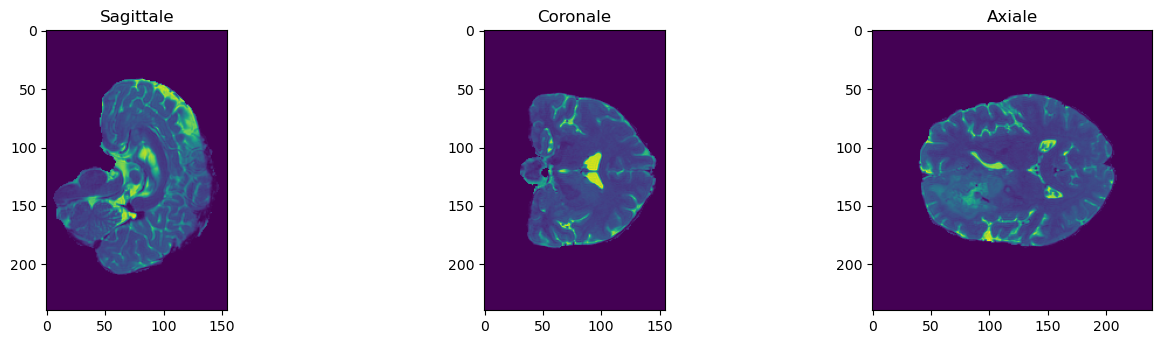

Coupes de t1ce


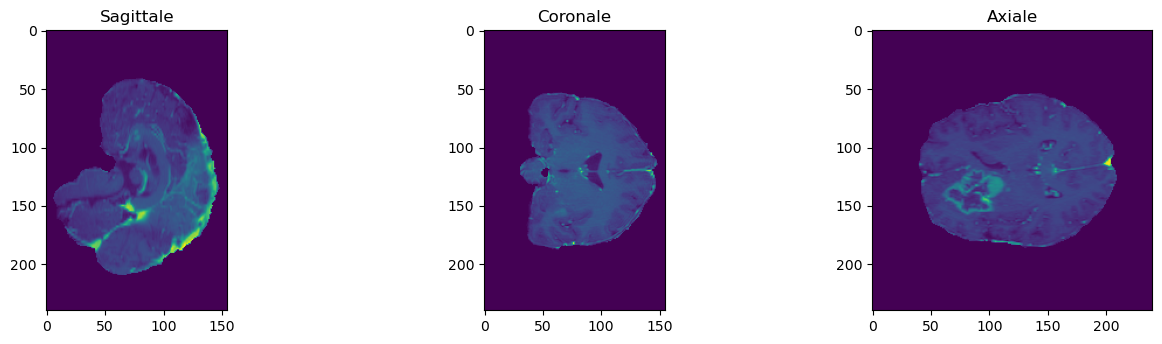

Coupes de t1


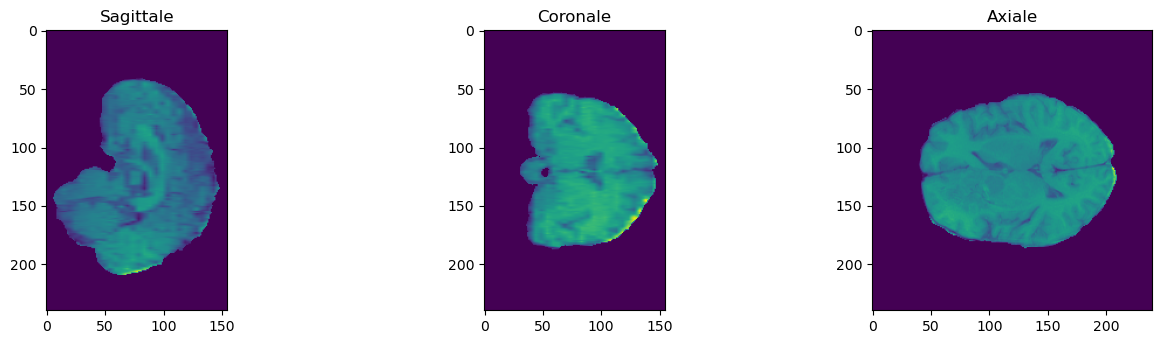

Coupes de flair


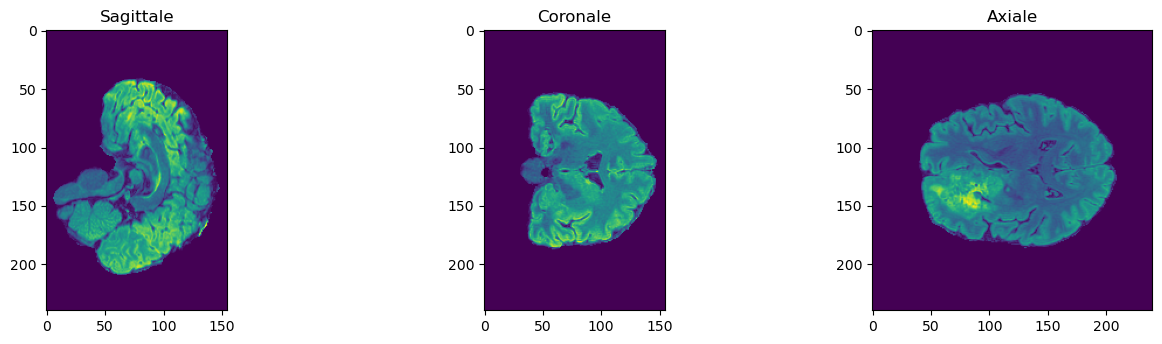

Coupes de seg


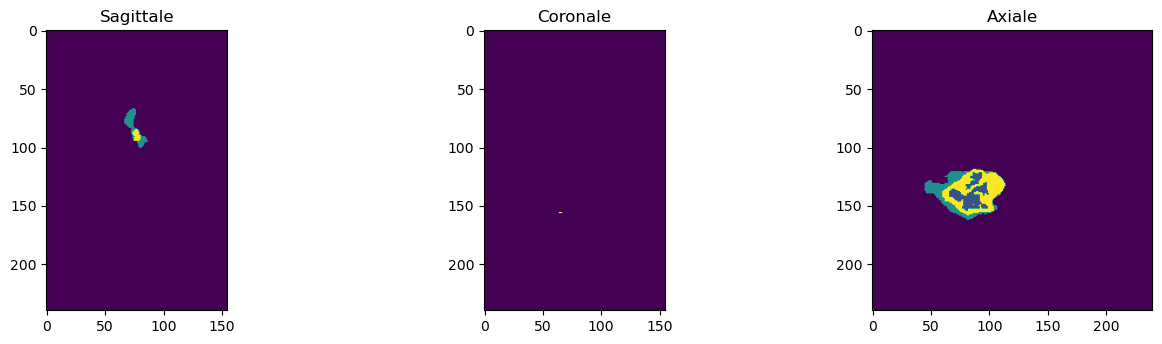

Nouveau patient :  00002
Nouveau patient :  00003
Nouveau patient :  00005
Nouveau patient :  00006
Nouveau patient :  00008
Nouveau patient :  00009
Nouveau patient :  00011
Nouveau patient :  00012
Nouveau patient :  00014
Nouveau patient :  00016
Nouveau patient :  00017
Nouveau patient :  00018
Nouveau patient :  00019
Nouveau patient :  00020
Nouveau patient :  00021
Nouveau patient :  00022
Nouveau patient :  00024
Nouveau patient :  00025
Nouveau patient :  00026
Nouveau patient :  00030
Nouveau patient :  00031
Nouveau patient :  00032
Nouveau patient :  00033
Nouveau patient :  00035
Nouveau patient :  00036
Nouveau patient :  00043
Nouveau patient :  00044
Nouveau patient :  00045
Nouveau patient :  00046
Nouveau patient :  00048
Nouveau patient :  00049
Nombre total de patients : 32


In [5]:
nb_patient = 0
for filename in filenames:
    if "t2" in filename:
        print("Nouveau patient : ", filename[10:15])
        if nb_patient == 0:
            PrintData(filename) # T2
            PrintData(filename[:16] + "t1ce.nii")
            PrintData(filename[:16] + "t1.nii")
            PrintData(filename[:16] + "flair.nii")
            PrintData(filename[:16] + "seg.nii")
        nb_patient += 1
print("Nombre total de patients :", nb_patient)

In [6]:
# Limit the number of data to avoid overloading data, this can probably improved using np.memmap()
factor = 0.5
nb_patient_training = int(0.75 * nb_patient * factor)
nb_patient_validation = int(0.125 * nb_patient * factor)
nb_patient_test = int(0.125 * nb_patient * factor)

nb_patient = nb_patient_training + nb_patient_validation + nb_patient_test
print("Number of total patients :", nb_patient)
print("Number of training patients :", nb_patient_training)
print("Number of validation patients :", nb_patient_validation)
print("Number of test patients :", nb_patient_test)

Number of total patients : 16
Number of training patients : 12
Number of validation patients : 2
Number of test patients : 2


In [7]:
threashold_area = 100
nb_intersting_slices_training = 0
nb_intersting_slices_validation = 0
cur_nb_patient = 0

for filename in filenames:
    if "seg" in filename:
        if (cur_nb_patient < nb_patient_training) or (cur_nb_patient >= nb_patient_training and cur_nb_patient < nb_patient_training + nb_patient_validation):
            if cur_nb_patient < nb_patient_training:
                print("PATIENT (training):", filename[10:15])
            else:
                print("PATIENT (validation):", filename[10:15])
            segs = nib.load(filename).get_fdata()
            sx, sy, sz = segs.shape
            
            for z in range(0, sz):
                slice = segs[:, :, z]
                if np.sum(slice >= 0) >= threashold_area:
                    if cur_nb_patient < nb_patient_training:
                        nb_intersting_slices_training += 1
                    if cur_nb_patient >= nb_patient_training and cur_nb_patient < nb_patient_training + nb_patient_validation:
                        nb_intersting_slices_validation += 1
            cur_nb_patient += 1

print("Number of intersting slices for training:", nb_intersting_slices_training)
print("Number of intersting slices for validation:", nb_intersting_slices_validation)

PATIENT (training): 00000
PATIENT (training): 00002
PATIENT (training): 00003
PATIENT (training): 00005
PATIENT (training): 00006
PATIENT (training): 00008
PATIENT (training): 00009
PATIENT (training): 00011
PATIENT (training): 00012
PATIENT (training): 00014
PATIENT (training): 00016
PATIENT (training): 00017
PATIENT (validation): 00018
PATIENT (validation): 00019
Number of intersting slices for training: 1860
Number of intersting slices for validation: 310


In [8]:
def Normalisation(img):
    mu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return ((img - mu) / sigma)

In [9]:
x_train = np.zeros((nb_intersting_slices_training, sx, sy, 4))
y_train = np.zeros((nb_intersting_slices_training, sx, sy, 1))

x_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 4))
y_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 1))

In [10]:
numero_intersting_slices_training = 0
numero_intersting_slices_validation = 0
cur_nb_patient = 0

for filename in filenames:
    if "t2" in filename:
        if (cur_nb_patient < nb_patient_training) or (cur_nb_patient >= nb_patient_training and cur_nb_patient < nb_patient_training + nb_patient_validation):
            if cur_nb_patient < nb_patient_training:
                print("PATIENT (training):", filename[10:15])
            else:
                print("PATIENT (validation):", filename[10:15])
                
            T2 = nib.load(filename).get_fdata()
            T1 = nib.load(filename[:16] + "t1.nii").get_fdata()
            T1ce = nib.load(filename[:16] + "t1ce.nii").get_fdata()
            flair = nib.load(filename[:16] + "flair.nii").get_fdata()
            segs = nib.load(filename[:16] + "seg.nii").get_fdata()
            
            sx, sy, sz = segs.shape
            segs = np.array(segs)
            
            T2_normalized = Normalisation(T2)
            T1_normalized = Normalisation(T1)
            T1ce_normalized = Normalisation(T1ce)
            flair_normalized = Normalisation(flair)
            
            segs_clipped = np.clip(segs, 0, 1)
            vt3d = np.where(np.isin(segs, [1, 2, 4]), 1, 0)
            
            for z in range(0, sz):
                slice = segs[:, :, z]
                if np.sum(slice >= 0) >= threashold_area:
                    if cur_nb_patient < nb_patient_training:
                        x_train[numero_intersting_slices_training, :, :, 0] = T2_normalized[:, :, z]
                        x_train[numero_intersting_slices_training, :, :, 1] = T1_normalized[:, :, z]
                        x_train[numero_intersting_slices_training, :, :, 2] = T1ce_normalized[:, :, z]
                        x_train[numero_intersting_slices_training, :, :, 3] = flair_normalized[:, :, z]
                        y_train[numero_intersting_slices_training, :, :, 0] = segs_clipped[:, : , z]
                        numero_intersting_slices_training += 1
                            
                    if cur_nb_patient >= nb_patient_training and cur_nb_patient < nb_patient_training + nb_patient_validation:
                        x_valid[numero_intersting_slices_validation, :, :, 0] = T2_normalized[:, :, z]
                        x_valid[numero_intersting_slices_validation, :, :, 1] = T1_normalized[:, :, z]
                        x_valid[numero_intersting_slices_validation, :, :, 2] = T1ce_normalized[:, :, z]
                        x_valid[numero_intersting_slices_validation, :, :, 3] = flair_normalized[:, :, z]
                        y_valid[numero_intersting_slices_validation, :, :, 0] = vt3d[:, :, z]
                        numero_intersting_slices_validation += 1
        cur_nb_patient += 1

PATIENT (training): 00000
PATIENT (training): 00002
PATIENT (training): 00003
PATIENT (training): 00005
PATIENT (training): 00006
PATIENT (training): 00008
PATIENT (training): 00009
PATIENT (training): 00011
PATIENT (training): 00012
PATIENT (training): 00014
PATIENT (training): 00016
PATIENT (training): 00017
PATIENT (validation): 00018
PATIENT (validation): 00019


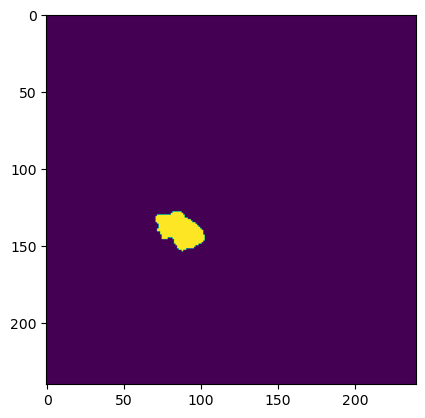

In [11]:
plt.imshow(y_train[52, :, :,])

In [12]:
np.unique(segs)

array([0., 1., 2., 4.])

# U-Net

In [13]:
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet_model(input_size = (sx, sy, 4)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(nbf512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(nbf256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(nbf128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(nbf64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def ComputeDice(X, Y):
    Xbin = X > 0
    Ybin = Y > 0
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec) / (cardX + cardY)
        print("Dice = ", dice)
        return dice
    else:
        return 0

# Deep Ensemble

In [15]:
def create_deep_ensemble_model(ensemble_size, input_shape):
    ensemble_models = []
    for _ in range(ensemble_size):
        ensemble_models.append(unet_model())
    return ensemble_models

def train_deep_ensemble(ensemble_models, x_train, y_train):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto',baseline=None,restore_best_weights=True)
    
    for model in ensemble_models:
        model.fit(x=x_train, y=y_train, batch_size=32, epochs=NB_EPOCHS_MAX, verbose=1,
                  callbacks=[early_stopping], initial_epoch=0, validation_data=(x_valid, y_valid))

## Deep Mind

In [16]:
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model, load_model
epsilon = 0.01

def _proper_scoring_rule(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

def train_deep_ensemble_deep_mind(models, X_train, y_train, epochs=50, batch_size=32):
    for epoch in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        print(f'Epoch {epoch}')
        for m in range(len(models)):
            for i in range(0, len(X_train), batch_size):
                x_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Sample data point nm randomly for each net
                idx = np.random.choice(len(X_train), size=len(x_batch), replace=True)
                x_nm = X_train[idx]
                y_nm = y_train[idx]

                # Generate adversarial example
                perturbation = epsilon * np.sign(np.random.normal(size=x_batch.shape))
                x_0_nm = x_batch + perturbation

                # Minimize the proper scoring rule + adversarial scoring rule
                with tf.GradientTape() as tape:
                    y_pred = models[m](x_batch)
                    loss = _proper_scoring_rule(y_batch, y_pred)

                    if epoch > 0:
                        y_pred_adversarial = models[m](x_0_nm)
                        loss += _proper_scoring_rule(y_batch, y_pred_adversarial)

                gradients = tape.gradient(loss, models[m].trainable_variables)
                models[m].optimizer.apply_gradients(zip(gradients, models[m].trainable_variables))

In [17]:
# You can modify those parameters
TRAINING_MODE = True
DEEP_MIND = True
ENSEMBLE = DEEP_MIND or False
NB_EPOCHS_MAX = 50
ENSEMBLE_SIZE = 5

ensemble_models = None
model = None
if TRAINING_MODE:
    if ENSEMBLE:
        ensemble_models = create_deep_ensemble_model(ENSEMBLE_SIZE, input_shape = (sx, sy, 4))
        if DEEP_MIND:
            train_deep_ensemble_deep_mind(ensemble_models, x_train, y_train, epochs=NB_EPOCHS_MAX, batch_size=32)
            for i in range(ENSEMBLE_SIZE):
                save_model(ensemble_models[i], '/kaggle/working/' + f"model{i}_dm.hdf5")
        else:
            train_deep_ensemble(ensemble_models, x_train, y_train)
            for i in range(ENSEMBLE_SIZE):
                ensemble_models[i].save_weights('/kaggle/working/' + f"model{i}.hdf5")
    else:
        model = unet_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto',baseline=None,restore_best_weights=True)
        model.fit(x=x_train, y=y_train, batch_size=32, epochs=NB_EPOCHS_MAX, verbose=1,
                  callbacks=[early_stopping], initial_epoch=0, validation_data=(x_valid, y_valid))
        model.save('/kaggle/working/model.hdf5')
else:
    if ENSEMBLE:
        ensemble_models = create_deep_ensemble_model(ENSEMBLE_SIZE, input_shape = (sx, sy, 4))
        for i in range(ENSEMBLE_SIZE):
            if DEEP_MIND:
                ensemble_models[i] = load_model('/kaggle/input/pfe-brats-models/' + f"model{i}_dm.hdf5", custom_objects={'_proper_scoring_rule': _proper_scoring_rule})
            else:
                ensemble_models[i].load_weights('/kaggle/input/pfe-brats-models/' + f"model{i}.hdf5")
    else:
        model = unet_model()
        model.load_weights('/kaggle/input/pfe-brats-models/model.hdf5')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


# Uncertainty

In [18]:
def calculate_entropy(predictions):
    n_predictions = len(predictions)
    if n_predictions <= 1:
        return 0
    
    value, counts = np.unique(predictions, return_counts=True)
    probs = counts / n_predictions
    n_classes = np.count_nonzero(probs)
    if n_classes <= 1:
        return 0
    
    entropy = 0.0
    for i in probs:
        entropy = i * np.log2(i)
    return entropy

In [19]:
def analyze_uncertainty(predictions):
    predictive_variance = np.var(predictions)
    predictive_entropy = calculate_entropy(predictions)
    return np.array([predictive_variance, predictive_entropy])

In [20]:
def post_processing(predictions, alpha=0.0):
    for i in range(predictions.shape[0]):
        mini, maxi = np.min(predictions[i, ...]), np.max(predictions[i, ...])
        mean = np.mean(np.array([mini, maxi]))
        predictions[i, ...] = (predictions[i, ...] > mean + alpha)
    return predictions

In [21]:
def get_uncertainty_map(predictions):
    uncertainty_map = np.zeros((16, 240, 240, 1))
    
    predictions = post_processing(predictions)
    uncertainty_map = np.sum(predictions, axis=0)
    reverse_mapping = {0: 0, 1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
    uncertainty_map = np.vectorize(reverse_mapping.get)(uncertainty_map)
    
    return uncertainty_map

# Prediction

In [22]:
def batchensemble_predict(ensemble_models, input_data, batch_size):
    num_models = len(ensemble_models)
    num_samples = input_data.shape[0]
    ensemble_predictions = []
    uncertainties = np.zeros((num_samples // batch_size, 2))

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_input = input_data[start_idx:end_idx]
        batch_predictions = []

        for j, model in enumerate(ensemble_models):
            batch_predictions.append(model.predict(batch_input, verbose=0)) 

        batch_predictions = np.array(batch_predictions)
        uncertainty_map = get_uncertainty_map(batch_predictions)
        batch_ensemble_prediction = np.mean(batch_predictions, axis=0)
        ensemble_predictions.append(batch_ensemble_prediction) 
        
        uncertainties[start_idx] = analyze_uncertainty(batch_predictions)

    ensemble_predictions = np.vstack(ensemble_predictions)
    return (post_processing(ensemble_predictions), uncertainties, uncertainty_map)

# Testing

## Testing Basic U-NET

In [23]:
if not ENSEMBLE: 
    nb_patient = 0
    new_nb_patient_test = 0
    dices = []

    for filename in filenames:
        if "t2" in filename:
            if nb_patient <= nb_patient_training + nb_patient_validation and nb_patient < nb_patient_training + nb_patient_validation + nb_patient_test:
                print("PATIENT (test):", filename[10:15])
                T2 = nib.load(filename).get_fdata()
                T1 = nib.load(filename[:16] + "t1.nii").get_fdata()
                T1ce = nib.load(filename[:16] + "t1ce.nii").get_fdata()
                flair = nib.load(filename[:16] + "flair.nii").get_fdata()
                segs = nib.load(filename[:16] + "seg.nii").get_fdata()
                
                sx, sy, sz = segs.shape
                segs = np.array(segs)
                prediction3D_10 = np.zeros((sx, sy, sz))
            
                T2_normalized = Normalisation(T2)
                T1_normalized = Normalisation(T1)
                T1ce_normalized = Normalisation(T1ce)
                flair_normalized = Normalisation(flair)
            
                VT10 = np.where(np.isin(segs, [1, 2, 4]), 1, 0)
                
                for z in range(0, sz):
                    input_network = np.zeros((1, sx, sy, 4))
                    input_network[0, :, :, 0] = T2_normalized[:, :, z]
                    input_network[0, :, :, 1] = T1_normalized[:, :, z]
                    input_network[0, :, :, 2] = T1ce_normalized[:, :, z]
                    input_network[0, :, :, 3] = flair_normalized[:, :, z]
                
                    prediction10 = np.round(model.predict(input_network, verbose=0)).reshape((sx, sy))
                    prediction3D_10[:, :, z] = np.copy(prediction10)
                    
                    # Display
                    prediction_to_plot = np.copy(prediction3D_10)
                    VT_to_plot = np.copy(VT10[:, :, z])
                    if np.sum(VT_to_plot) > 100 and np.sum(prediction3D_10[:, :, z]) > 100:
                        VT_to_plot[0, 0] = 1.0 
                        prediction_to_plot[0, 0] = 1.0
                        dice = ComputeDice(prediction3D_10, VT10)
                        dices.append(dice)
                        
                        if z % 10 == 0:
                            fast_display(flair_normalized[:, :, z].reshape((sx, sy)), prediction3D_10[:, :, z], VT_to_plot, 
                                titles=['Flair', 'Prediction', 'Ground Truth'])
                new_nb_patient_test += 1 
        nb_patient += 1

## Testing Ensembles

Dice =  0.960098979276214
Dice =  0.9819770617149098
Dice =  0.8185328185328186
Dice =  0.9131614654002713
Dice =  0.9760020423793719
Dice =  0.9795221843003413
Dice =  0.9886455798864558


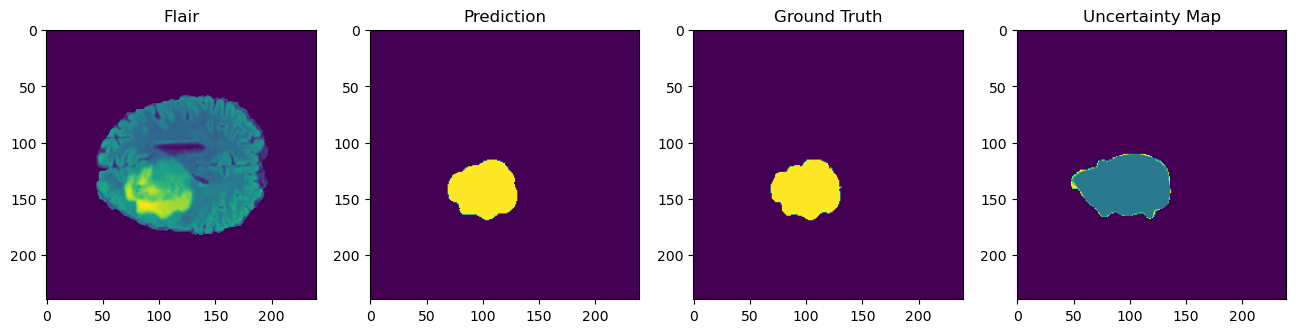

Dice =  0.973305954825462
Dice =  0.9764789736279401
Dice =  0.9901705115346038
Dice =  0.9769288017861573
Dice =  0.9308755760368663
Dice =  0.985207100591716
Dice =  0.9883242887682947


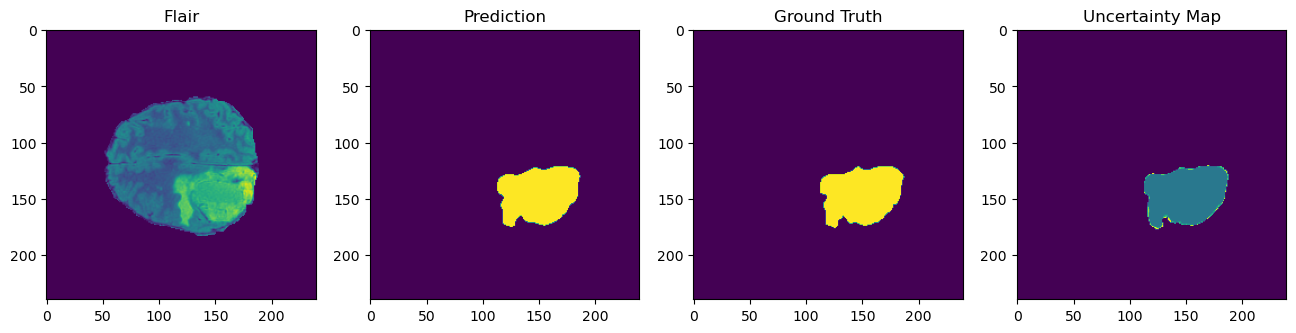

Dice =  0.9697472026523001
Dice =  0.9657320872274143
Dice =  0.9917284654877353
Dice =  0.9852579852579852
Dice =  0.9648077964266378
Dice =  0.9263502454991817
Dice =  0.976051779935275
Dice =  0.9286754002911208
Dice =  0.9275028768699655
Dice =  0.9715869715869716
Dice =  0.8934707903780069
Dice =  0.9827192696446039
Dice =  0.9808203009737385
Dice =  0.9704142011834319
Dice =  0.9844142785319256
Dice =  0.9912107623318386
Dice =  0.9829305715381664
Dice =  0.9824709609292502
Dice =  0.9406175771971497
Dice =  0.960438222763238
Dice =  0.981599699586932
Dice =  0.8788927335640139
Dice =  0.972032902467685
Dice =  0.9746938775510204
Dice =  0.9251471825063078
Dice =  0.9694587239189598
Dice =  0.9778549717759444


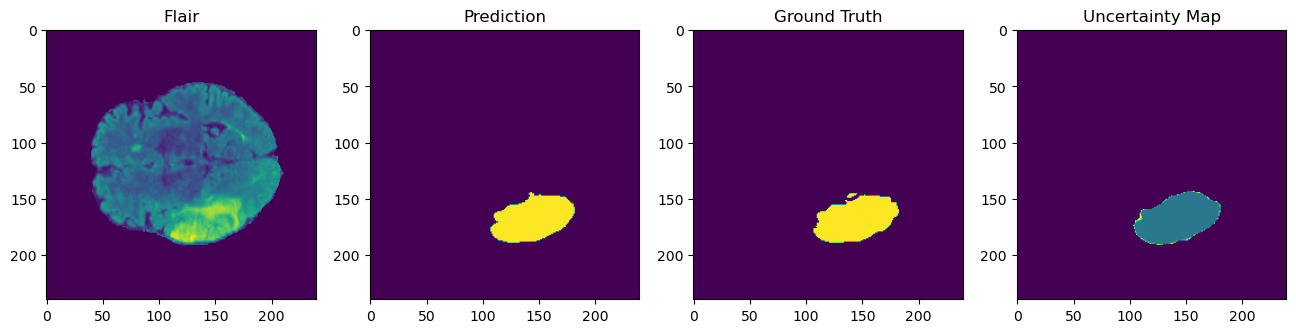

Dice =  0.9650669278485146
Dice =  0.9493827160493827
Dice =  0.9222144358794674
Dice =  0.9603207521083921
Dice =  0.9595858383433534
Dice =  0.5933250927070457
Dice =  0.9178695868591339
Dice =  0.9257915567282322
Dice =  0.9236983842010772


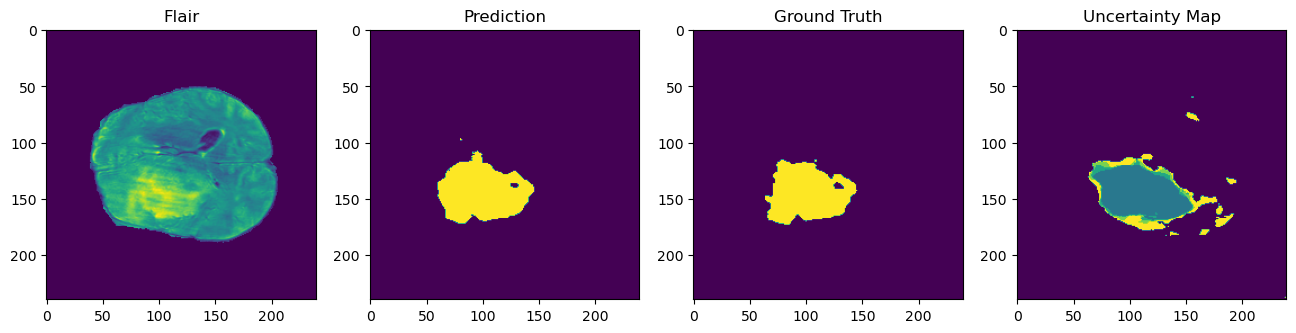

Dice =  0.8951048951048951
Dice =  0.21031746031746032
Dice =  0.8413836086008102
Dice =  0.5642558278541542


In [24]:
if ENSEMBLE: 
    batch_predictions = []
    uncertainties = []
    dices = []
    batch_size = 16
    nb_patient = 0
    new_nb_patient_test = 0

    for filename in filenames:
        if "t2" in filename:
            if nb_patient <= nb_patient_training + nb_patient_validation and nb_patient < nb_patient_training + nb_patient_validation + nb_patient_test:
                T2 = nib.load(filename).get_fdata()
                T1 = nib.load(filename[:16] + "t1.nii").get_fdata()
                T1ce = nib.load(filename[:16] + "t1ce.nii").get_fdata()
                flair = nib.load(filename[:16] + "flair.nii").get_fdata()
                segs = nib.load(filename[:16] + "seg.nii").get_fdata()
                sx, sy, sz = segs.shape
                segs = np.array(segs)
                prediction3D_10 = np.zeros((sx, sy, sz))
                T2_normalized = Normalisation(T2)
                T1_normalized = Normalisation(T1)
                T1ce_normalized = Normalisation(T1ce)
                flair_normalized = Normalisation(flair)
                VT10 = np.where(np.isin(segs, [1, 2, 4]), 1, 0)

                for z in range(0, sz):
                    input_network = np.zeros((sx, sy, 4))
                    input_network[:, :, 0] = T2_normalized[:, :, z]
                    input_network[:, :, 1] = T1_normalized[:, :, z]
                    input_network[:, :, 2] = T1ce_normalized[:, :, z]
                    input_network[:, :, 3] = flair_normalized[:, :, z]
                    batch_predictions.append(input_network)

                    if len(batch_predictions) == batch_size:
                        # Predict for the batch of inputs
                        batch_predictions = np.array(batch_predictions)
                        batch_predictions, cur_uncertainties, uncertainty_map = batchensemble_predict(ensemble_models, batch_predictions, batch_size)
                        uncertainties.append(cur_uncertainties)

                        # Reshape and append batch predictions to the final result
                        for batch_pred in batch_predictions:
                            prediction3D_10[:, :, z - batch_size + 1:z + 1] = batch_pred

                        # Clear the batch_predictions list
                        batch_predictions = []

                    if np.sum(VT10[:, :, z]) > 100 and np.sum(prediction3D_10[:, :, z]) > 100:
                        VT_to_plot = np.copy(VT10[:, :, z])
                        VT_to_plot[0, 0] = 1.0
                        dice = ComputeDice(prediction3D_10[:, :, z], VT10[:, :, z])
                        dices.append(dice)
                        if z % 10 == 0:
                            fast_display(flair_normalized[:, :, z].reshape((sx, sy)), prediction3D_10[:, :, z], VT_to_plot, uncertainty_map[z % batch_size], 
                                        titles=['Flair', 'Prediction', 'Ground Truth', 'Uncertainty Map'])
                new_nb_patient_test += 1
                nb_patient += 1

# Results uncertainty

Median dice : 0.967595405573187


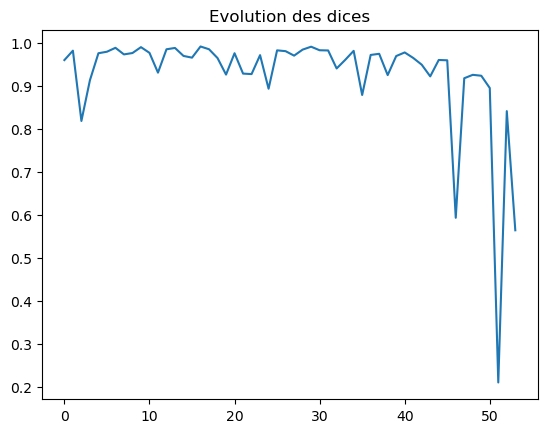

In [25]:
dices = np.array(dices)
plt.title('Evolution des dices')
plt.plot(dices)

mean_dice = np.median(dices)
print(f"Median dice : {mean_dice}")

Mean variance : 0.009024493594727668


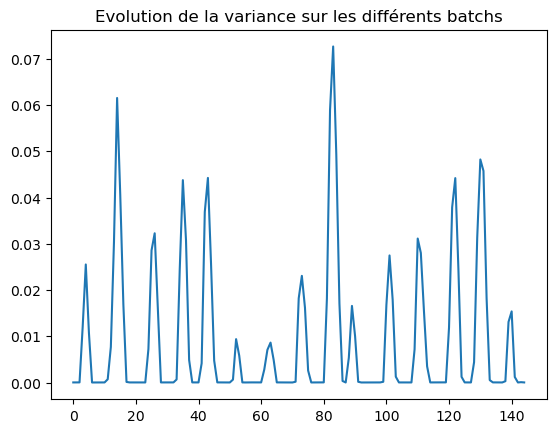

In [26]:
if ENSEMBLE:
    uncertainties = np.array(uncertainties)
    mean_variance = np.mean(uncertainties[:, 0, 0])

    plt.title('Evolution de la variance sur les différents batchs')
    plt.plot(uncertainties[:, 0, 0])

    print(f"Mean variance : {mean_variance}")

Mean entropy : 127049.47462740983


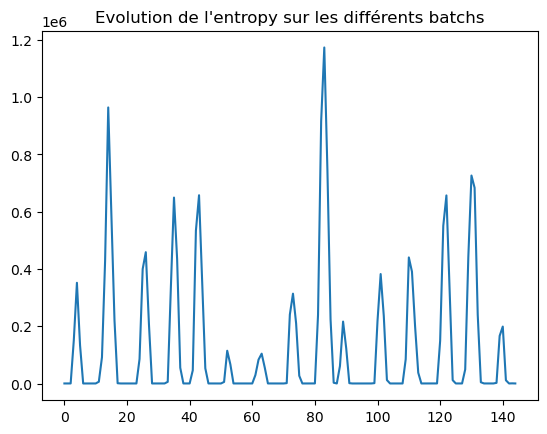

In [27]:
if ENSEMBLE:
    mean_entropy = np.mean(uncertainties[:, 0, 1])
    print(f"Mean entropy : {mean_entropy}")

    plt.title('Evolution de l\'entropy sur les différents batchs')
    plt.plot(uncertainties[:, 0, 1])

# Areas for improvement

In [28]:
# Idea to calculcate the entropy locally
from scipy.ndimage import uniform_filter
from scipy.stats import entropy

def block_entropy(image, block_size=3):
    local_entropy = np.zeros_like(image)

    for i in range(image.shape[0] - block_size + 1):
        for j in range(image.shape[1] - block_size + 1):
            block = image[i:i+block_size, j:j+block_size]
            hist, _ = np.histogram(block.flatten(), bins=256, range=(0, 1))
            pk = hist / np.sum(hist)
            epsilon = 1e-10
            pk[pk == 0] = epsilon
            local_entropy[i:i+block_size, j:j+block_size] = entropy(pk, base=2)

    return local_entropy

def visualize_entropy_map(entropy_map):
    plt.imshow(entropy_map, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Entropy Map')
    plt.show()

In [29]:
def get_diff(mask1, mask2):
    union = np.logical_or(mask1, mask2, casting='safe')
    error = mask1 - mask2
    plt.imshow(error, cmap='gray')
    plt.title('Error')
    plt.show()
    for i in range(union.shape[0]):
        for j in range(union.shape[1]):
            if union[i][j]:
                union[i][j] = error[i][j]
    union = np.where(error, error, union)
    return union